## AutoEncoder 실습
- FashionMNIST 데이터를 이용해 기본적인 MLP 구조의 AutoEncoder 모델 설계.
- 원본 데이터를 생성.

### 모델 설계 순서
1. Module Import.
2. 장비 확인.
3. Fashion MNIST 데이터 다운로드.
    - Train set, Test set 분리하기.
4. 데이터 확인하기 (1)
5. 데이터 확인하기 (2)
6. AutoEncoder(AE) 모델 설계.
7. Optimizer, Objective Function 설정.
8. Train set에 대한 모델의 성능을 확인하는 함수 정의.
9. Test set에 대한 모델의 성능을 확인하는 함수 정의.
10. AutoEncoder 학습을 실행하면서 Test set의 Reconstruction Error 확인.

In [2]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F 
# torch.nn Module 중에서도 자주 이용되는 함수를 'F'로 지정.
from torchvision import transforms, datasets 
# 컴퓨터 비전 연구 분야에서 자주 이용되는 'torchvision' Module 내의 'transforms', 'datasets' 함수를 import. 

In [3]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' device:', DEVICE)

Using PyTorch version: 1.10.0+cpu  device: cpu


In [4]:
BATCH_SIZE = 32 # (1)
EPOCHS = 10     # (2)

- 하이퍼파라미터 지정 시 보통 영어 대문자로 표기.
1. BATCH_SIZE
    - 모델을 학습할 때 필요한 데이터 개수의 단위.
    - Mini-Batch 1개당 데이터가 32개로 구성.
        - Iteration : 1개의 Mini-Batch를 통해 학습하는 횟수.
        - Epoch : 전체 데이터를 이용해 학습을 진행한 횟수.
2. EPOCHS
    - 존재하고 있는 Mini-batch를 전부 이용하는 횟수.
        - 즉) 전체 데이터셋을 10번 반복해 학습.

In [5]:
''' 3. FasionMNIST 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.FashionMNIST(root = '../data/FashionMNIST',     # (1)
                                    train = True,
                                    download = True,
                                    transform = transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root = '../data/FashionMNIST',     # (2)
                                    train = False,
                                    transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,   # (3)
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,   # (4)
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

- (1), (2) : FashionMNIST 데이터셋을 다운로드
    - root : 데이터가 저장될 장소를 지정.
    - train : 학습용 데이터인지, 검증용 데이터인지 지정.
    - download
    - transform : 이미지를 다운로드 할 때 기본적인 전처리를 동시에 진행.
        - ToTensor() : AE의 Input으로 이용하기 위해 데이터를 tensor 형태로 변경.
        - 0 ~ 255 범위의 스칼라 값으로 구성된 픽셀을 0 ~ 1 범위로 정규화.
            - AE를 비롯한 인공 신경망 모델은 Input 데이터 값의 크기가 커질수록 불안정, 과적합되기 때문.
- (3), (4) : 데이터셋을 Mini-Batch 단위로 분리해 지정.
    - DataLoader : 이미지 데이터를 Batch Size만큼 묶어 1개의 Mini-Batch를 구성할 수 있음.
        - dataset : 
        - batch_size : 
        - shuffle : 데이터의 순서를 섞고자 할 때 이용.
            - Label 값에 집중해 학습을 진행하지 못하게 방지.

In [6]:
''' 4. 데이터 확인하기 (1) '''
for (x_train, y_train) in train_loader:
    print('x_train : ', x_train.size(), 'type : ', x_train.type())
    print('y_train : ', y_train.size(), 'type : ', y_train.type())
    break

x_train :  torch.Size([32, 1, 28, 28]) type :  torch.FloatTensor
y_train :  torch.Size([32]) type :  torch.LongTensor


- x_train
    - 32개의 이미지 데이터가 1개의 Mini-Batch를 구성.
    - 가로 28, 세로 28개의 픽셀로 구성.
    - channel=1 이므로 그레이스케일.
- y_train
    - 32개의 이미지 데이터에 Label값이 1개씩 존재. (32개의 값을 지님)
- torch.Size(Mini-Batch, Channel, Height, Width)의 형태.

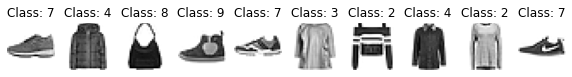

In [7]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(x_train[i, :, :, :].numpy().reshape(28, 28), cmap='gray_r')
    plt.title('Class: ' + str(y_train[i].item()))

In [8]:
''' 6. AutoEncoder (AE) 모델 설계하기 '''
class AE(nn.Module):                                             # (1)
    def __init__(self):                                          # (2)
        super(AE, self).__init__()                                # (3)
        
        self.encoder = nn.Sequential(nn.Linear(28 * 28, 512),    # (4), (5) 
                                    nn.ReLU(),                   # (6)
                                    nn.Linear(512, 256),         # (7)
                                    nn.ReLU(),                   # (8)
                                    nn.Linear(256, 32),)         # (9)
        
        self.decoder = nn.Sequential(nn.Linear(32, 256),         # (10), (11)
                                    nn.ReLU(),                   # (12)
                                    nn.Linear(256, 512),         # (13)
                                    nn.ReLU(),                   # (14)
                                    nn.Linear(512, 28 * 28),)    # (15)
        
    def forward(self, x):                                        # (16)
        encoded = self.encoder(x)                                # (17)
        decoded = self.decoder(encoded)                          # (18)
        return encoded, decoded                                 # (19)

1. AE 클래스 : nn.Module 클래스를 상속.
2. AE 클래스의 인스턴스를 생성했을 때 지니게 되는 성질을 정의.
3. nn.Module 내에 있는 메서드를 상속받아 이용.

#### 인코더 부분
4. nn.Sequential
    - 인코더 단위를 한 번에 정의.
5. FashionMNIST 데이터는 28 * 28 크기의 이미지.
    - 첫 번째 레이어의 Input 노드 수를 28 * 28로 설정.
    - 첫 번째 레이어의 Output 노드 수를 512 크기로 설정.
6. 첫 번째 Output에 대해 ReLU() 비선형 함수를 적용해 두 번째 레이어의 Input으로 전달.
7. 두 번째 Input 크기는 512, Output 크기는 256.
8. 두 번째 Output에 대해 ReLU() 비선형 함수를 적용해 세 번째 레이어의 Input으로 전달.
9. 세 번째 Input 크기는 256, Output 크기는 32.

#### 디코더 부분
10. nn.Sequential
    - 디코더 단위를 한 번에 정의.
11. 인코더로 생성한 Latent Variable Vector를 Input으로 이용.
    - 첫 번째 레이어의 Input 노드 수를 32로 설정.
    - 첫 번째 레이어의 Output 노드 수를 256으로 설정.
12. 첫 번째 Output에 대해 ReLU() 비선형 함수를 적용해 두 번째 레이어의 Input으로 전달.
13. 두 번째 Input 크기는 256, Output 크기는 512.
14. 두 번째 Output에 대해 ReLU() 비선형 함수를 적용해 세 번째 레이어의 Input으로 전달.
15. 세 번째 Input 크기는 512, Output 크기는 기존 이미지 크기인 28 * 28.
    - 원래 이미지 데이터와 Loss를 계산하기 위함.
16. 인코더와 디코더에 대해 Forward Propagation을 정의.
    - 인코더와 디코더에 데이터를 입력 ~ Output계산까지의 과정.
17. Encoded
    - 이미지 데이터를 사전에 정의한 인코더의 Input으로 이용.
    - Latent Variable Vector을 생성.
18. decoded
    - Latent Variable Vector 값이 저장된 Encoded를 Input으로 이용.
19. 최종 계산된 두 결과값을 반환.

In [9]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = AE().to(DEVICE)  # (1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # (2)
criterion = nn.MSELoss() # (3)

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


1. 정의한 AE 모델을 기존에 선정한 DEVICE에 할당.
    - device를 이용해 AE모델을 완성하기 위함.
2. Back Propagation을 통해 파라미터를 업데이트할 때 이용하는 Optimizer를 정의.
    - eta = 0.001
    - 보통 Adam을 기본 옵션으로 설정.
3. MSE를 이용해 계산.

In [10]:
''' 8. AE 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()                                             # (1)
    for batch_idx, (image, _) in enumerate (train_loader):   # (2)
        image = image.view(-1, 28 * 28).to(DEVICE)           # (3)
        target = image.view(-1, 28 * 28).to(DEVICE)          # (4)
        optimizer.zero_grad()                                # (5)
        encoded, decoded = model(image)                      # (6)
        loss = criterion(decoded, target)                    # (7)
        loss.backward()                                      # (8)
        optimizer.step()                                     # (9)
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}'.format(Epoch, batch_idx * len(image),
                                                                               len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                                                                               loss.item()))

- 기존 정의 이미지 데이터와 레이블 데이터를 이용해 MLP 모델을 학습하는 train 함수.
1. AE 모델을 학습 상태로 지정.
2. train_loader
    - 학습에 이용되는 이미지, 레이블 데이터가 Mini-Batch 단위로 묶여 저장.
    - 이를 순서대로 이용해 AE 모형을 학습.
        - 이 예제에서는 레이블 데이터가 아니라 입력 데이터를 타깃으로 학습. (레이블 데이터를 이용할 필요가 없으므로 _로 생략)
3. Mini-Batch 내에 있는 이미지 데이터를 기존에 정의한 장비에 할당.
    - AE의 Input은 28 * 28 크기의 1차원 레이어.
        - 2차원 이미지 데이터를 1차원 데이터로 재구성해 할당.
4. 

In [11]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_image = []
    gen_image = []
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.view(-1, 28 * 28).to(DEVICE)
            target = image.view(-1, 28 * 28).to(DEVICE)
            encoded, decoded = model(image)
            
            test_loss += criterion(decoded, image).item()
            real_image.append(image.to('cpu'))
            gen_image.append(decoded.to('cpu'))
            
    test_loss /= len(test_loader.dataset)
    return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000(0%)]	Train Loss: 0.178311
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.029970
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.019894
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.023706
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.019075
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.018724
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.017870
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.014756
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.014806
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.013194

[EPOCH: 1], 	Test Loss: 0.0005


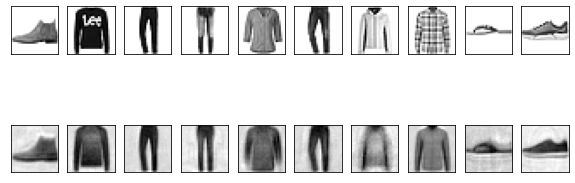

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.019645
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.015993
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.014068
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.015656
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.013353
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.013621
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.011881
Train Epoch: 2 [44800/60000(75%)]	Train Loss: 0.016230
Train Epoch: 2 [51200/60000(85%)]	Train Loss: 0.014407
Train Epoch: 2 [57600/60000(96%)]	Train Loss: 0.014746

[EPOCH: 2], 	Test Loss: 0.0004


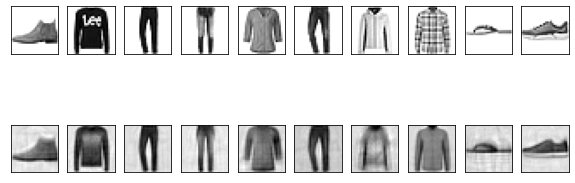

Train Epoch: 3 [0/60000(0%)]	Train Loss: 0.011862
Train Epoch: 3 [6400/60000(11%)]	Train Loss: 0.011828
Train Epoch: 3 [12800/60000(21%)]	Train Loss: 0.015483
Train Epoch: 3 [19200/60000(32%)]	Train Loss: 0.015512
Train Epoch: 3 [25600/60000(43%)]	Train Loss: 0.012335
Train Epoch: 3 [32000/60000(53%)]	Train Loss: 0.011402
Train Epoch: 3 [38400/60000(64%)]	Train Loss: 0.015200
Train Epoch: 3 [44800/60000(75%)]	Train Loss: 0.013708
Train Epoch: 3 [51200/60000(85%)]	Train Loss: 0.012082
Train Epoch: 3 [57600/60000(96%)]	Train Loss: 0.012561

[EPOCH: 3], 	Test Loss: 0.0004


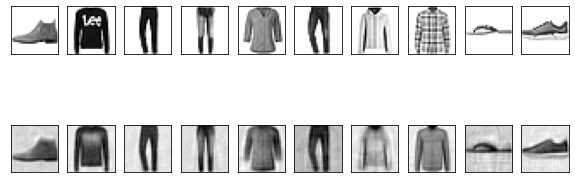

Train Epoch: 4 [0/60000(0%)]	Train Loss: 0.013056
Train Epoch: 4 [6400/60000(11%)]	Train Loss: 0.010955
Train Epoch: 4 [12800/60000(21%)]	Train Loss: 0.010209
Train Epoch: 4 [19200/60000(32%)]	Train Loss: 0.016783
Train Epoch: 4 [25600/60000(43%)]	Train Loss: 0.010824
Train Epoch: 4 [32000/60000(53%)]	Train Loss: 0.009759
Train Epoch: 4 [38400/60000(64%)]	Train Loss: 0.011450
Train Epoch: 4 [44800/60000(75%)]	Train Loss: 0.009700
Train Epoch: 4 [51200/60000(85%)]	Train Loss: 0.011745
Train Epoch: 4 [57600/60000(96%)]	Train Loss: 0.012920

[EPOCH: 4], 	Test Loss: 0.0004


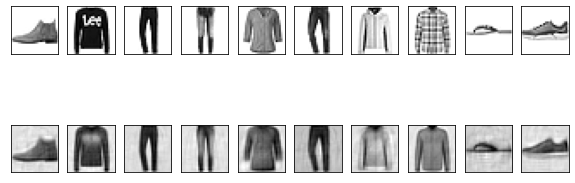

Train Epoch: 5 [0/60000(0%)]	Train Loss: 0.008476
Train Epoch: 5 [6400/60000(11%)]	Train Loss: 0.009097
Train Epoch: 5 [12800/60000(21%)]	Train Loss: 0.011294
Train Epoch: 5 [19200/60000(32%)]	Train Loss: 0.010606
Train Epoch: 5 [25600/60000(43%)]	Train Loss: 0.011919
Train Epoch: 5 [32000/60000(53%)]	Train Loss: 0.009620
Train Epoch: 5 [38400/60000(64%)]	Train Loss: 0.009779
Train Epoch: 5 [44800/60000(75%)]	Train Loss: 0.010489
Train Epoch: 5 [51200/60000(85%)]	Train Loss: 0.010379
Train Epoch: 5 [57600/60000(96%)]	Train Loss: 0.009238

[EPOCH: 5], 	Test Loss: 0.0003


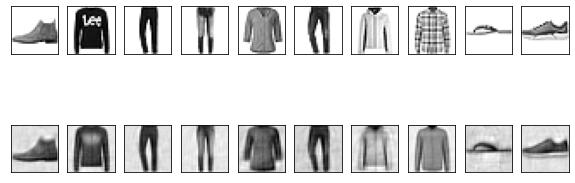

Train Epoch: 6 [0/60000(0%)]	Train Loss: 0.011127
Train Epoch: 6 [6400/60000(11%)]	Train Loss: 0.011796
Train Epoch: 6 [12800/60000(21%)]	Train Loss: 0.009234
Train Epoch: 6 [19200/60000(32%)]	Train Loss: 0.009452
Train Epoch: 6 [25600/60000(43%)]	Train Loss: 0.009102
Train Epoch: 6 [32000/60000(53%)]	Train Loss: 0.010145
Train Epoch: 6 [38400/60000(64%)]	Train Loss: 0.011021
Train Epoch: 6 [44800/60000(75%)]	Train Loss: 0.011870
Train Epoch: 6 [51200/60000(85%)]	Train Loss: 0.010924
Train Epoch: 6 [57600/60000(96%)]	Train Loss: 0.012182

[EPOCH: 6], 	Test Loss: 0.0003


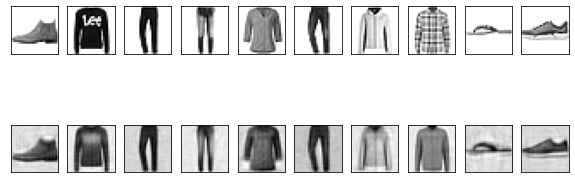

Train Epoch: 7 [0/60000(0%)]	Train Loss: 0.010728
Train Epoch: 7 [6400/60000(11%)]	Train Loss: 0.011613
Train Epoch: 7 [12800/60000(21%)]	Train Loss: 0.009519
Train Epoch: 7 [19200/60000(32%)]	Train Loss: 0.010848
Train Epoch: 7 [25600/60000(43%)]	Train Loss: 0.010005
Train Epoch: 7 [32000/60000(53%)]	Train Loss: 0.011877
Train Epoch: 7 [38400/60000(64%)]	Train Loss: 0.010019
Train Epoch: 7 [44800/60000(75%)]	Train Loss: 0.010243
Train Epoch: 7 [51200/60000(85%)]	Train Loss: 0.009513
Train Epoch: 7 [57600/60000(96%)]	Train Loss: 0.010821

[EPOCH: 7], 	Test Loss: 0.0003


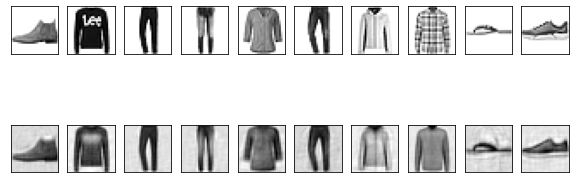

Train Epoch: 8 [0/60000(0%)]	Train Loss: 0.008648
Train Epoch: 8 [6400/60000(11%)]	Train Loss: 0.010113
Train Epoch: 8 [12800/60000(21%)]	Train Loss: 0.011884
Train Epoch: 8 [19200/60000(32%)]	Train Loss: 0.008674
Train Epoch: 8 [25600/60000(43%)]	Train Loss: 0.009995
Train Epoch: 8 [32000/60000(53%)]	Train Loss: 0.009920
Train Epoch: 8 [38400/60000(64%)]	Train Loss: 0.009572
Train Epoch: 8 [44800/60000(75%)]	Train Loss: 0.010547
Train Epoch: 8 [51200/60000(85%)]	Train Loss: 0.010244
Train Epoch: 8 [57600/60000(96%)]	Train Loss: 0.010223

[EPOCH: 8], 	Test Loss: 0.0003


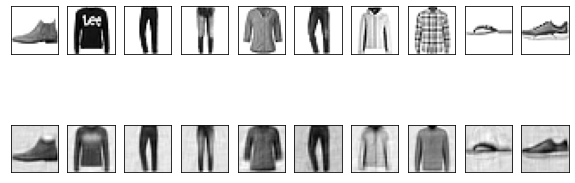

Train Epoch: 9 [0/60000(0%)]	Train Loss: 0.009813
Train Epoch: 9 [6400/60000(11%)]	Train Loss: 0.009826
Train Epoch: 9 [12800/60000(21%)]	Train Loss: 0.012496
Train Epoch: 9 [19200/60000(32%)]	Train Loss: 0.008338
Train Epoch: 9 [25600/60000(43%)]	Train Loss: 0.010034
Train Epoch: 9 [32000/60000(53%)]	Train Loss: 0.010537
Train Epoch: 9 [38400/60000(64%)]	Train Loss: 0.010505
Train Epoch: 9 [44800/60000(75%)]	Train Loss: 0.013169
Train Epoch: 9 [51200/60000(85%)]	Train Loss: 0.010027
Train Epoch: 9 [57600/60000(96%)]	Train Loss: 0.010753

[EPOCH: 9], 	Test Loss: 0.0003


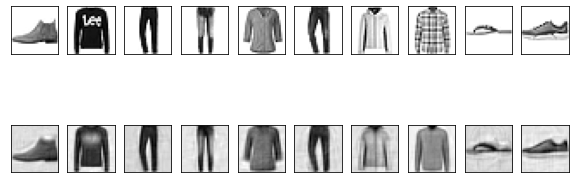

Train Epoch: 10 [0/60000(0%)]	Train Loss: 0.008711
Train Epoch: 10 [6400/60000(11%)]	Train Loss: 0.008465
Train Epoch: 10 [12800/60000(21%)]	Train Loss: 0.010223
Train Epoch: 10 [19200/60000(32%)]	Train Loss: 0.010941
Train Epoch: 10 [25600/60000(43%)]	Train Loss: 0.011386
Train Epoch: 10 [32000/60000(53%)]	Train Loss: 0.009180
Train Epoch: 10 [38400/60000(64%)]	Train Loss: 0.009402
Train Epoch: 10 [44800/60000(75%)]	Train Loss: 0.008001
Train Epoch: 10 [51200/60000(85%)]	Train Loss: 0.009777
Train Epoch: 10 [57600/60000(96%)]	Train Loss: 0.008028

[EPOCH: 10], 	Test Loss: 0.0003


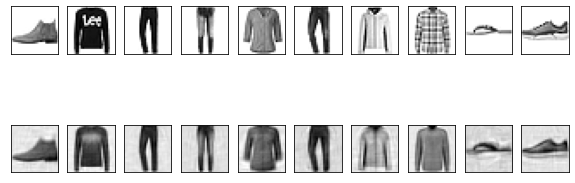

In [12]:
''' 10. AE 학습을 실행하며 Test set의 Reconstruction Error 확인하기 '''
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print('\n[EPOCH: {}], \tTest Loss: {:.4f}'.format(Epoch, test_loss))
    f, a = plt.subplots(2, 10, figsize = (10, 4))
    for i in range(10):
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap = 'gray_r')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
        
    for i in range(10):
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap='gray_r')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()